# Clustering IMDB movie actors

Defining notebook params:

In [1]:
seed = 42
n_processes = 12

n_spectral_components = 800

# n_clusters = 23
min_cluster_size = 150
min_samples = 10

pdf_postfix = "_custom_800"

Import stuff and ignore warnings:

In [2]:
import itertools
import pickle
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from IPython.core.display import display, HTML
from collections import Counter
from hdbscan import HDBSCAN
from matplotlib.axes._axes import _log
_log.setLevel("ERROR")
from matplotlib.patches import Patch
from networkx.algorithms.community import girvan_newman
from sklearn.cluster import SpectralClustering
from sklearn.manifold import spectral_embedding
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score, fowlkes_mallows_score, silhouette_score,\
    v_measure_score
from sklearn.utils.graph_shortest_path import graph_shortest_path
from umap import UMAP

from parallel_betweenness import betweenness_centrality_parallel

%matplotlib inline

Loading the network and taking the largest connected component:

In [3]:
np.random.seed(seed)

with open("data/edges.pkl", "rb") as f:
    G = nx.Graph()
    G.add_edges_from(pickle.load(f))
G.remove_nodes_from(set(nx.nodes(G)) - max(nx.connected_components(G), key=len))

adj_matrix = nx.to_numpy_array(G)
betweenness = betweenness_centrality_parallel(G, processes=n_processes)
node_list = list(G.nodes())

print(f"nodes: {len(node_list)}")
print(f"edges: {len(G.edges())}")

nodes: 13406
edges: 390859


Using Spectral Embedding, reducing dimensions with UMAP and clustering with HDBSCAN:

In [4]:
np.random.seed(seed)
random_state = np.random.RandomState(seed)

embedding = spectral_embedding(
    adj_matrix, n_components=n_spectral_components, drop_first=False, random_state=random_state
)
embedding = UMAP(
    n_components=2, n_neighbors=30, min_dist=0.0, random_state=random_state
).fit_transform(embedding)

In [5]:
np.random.seed(seed)
random_state = np.random.RandomState(seed)

clusters = HDBSCAN(
    min_samples=min_samples, min_cluster_size=min_cluster_size, core_dist_n_jobs=-1
).fit_predict(embedding)

# clusters = SpectralClustering(
#     n_clusters=n_clusters, affinity="precomputed", random_state=random_state, n_jobs=-1
# ).fit_predict(adj_matrix)

# it = girvan_newman(G)
# communities = list(itertools.takewhile(lambda c: len(c) <= n_clusters, it))[-1]
# clusters_dict = {node: i for i, c in enumerate(communities) for node in c}
# clusters = [clusters_dict[node] for node in node_list]

counter = Counter(clusters)
print(f"clusters: {np.amax(clusters) + 1}")
print(f"cluster sizes: {sorted(counter.items(), key=lambda x: x[1], reverse=True)}")
print(f"noise level: {np.round(counter[-1] / len(clusters), 3)}")

clusters: 15
cluster sizes: [(14, 5890), (6, 1008), (9, 837), (12, 823), (5, 725), (7, 634), (11, 578), (13, 484), (-1, 446), (10, 420), (4, 393), (8, 378), (1, 296), (2, 177), (3, 164), (0, 153)]
noise level: 0.033


Creating a dataframe from data and results:

In [6]:
np.random.seed(seed)

d = {"nconst": node_list, "cluster": clusters}
df_actor_info = pd.DataFrame(d)
df_actor_info["degree"] = df_actor_info["nconst"].apply(G.degree)

df_betweenness = pd.DataFrame(betweenness.items(), columns=["nconst", "betweenness"])
df_actor_info = df_actor_info.merge(df_betweenness, how="inner")

df_names_birth_years = pd.read_csv(
    "data/actor_names_birthyear.csv", sep=",", names=["nconst", "name", "birth_year"]
).reset_index()
df_names_birth_years = df_names_birth_years.drop(["index"], axis=1)
df_actor_info = df_actor_info.merge(df_names_birth_years, how="left")

df_birth_countries = pd.read_pickle("data/birth_countries.pkl")
df_actor_info = df_actor_info.merge(df_birth_countries, how="left")

Clustering performance evaluation with labels:

In [7]:
np.random.seed(seed)

df_eval_wl = df_actor_info[(df_actor_info["birth_country"].notna()) & (df_actor_info["cluster"] != -1)]
df_eval_wl = df_eval_wl.reset_index().drop(["index"], axis=1)
birth_countries = df_eval_wl['birth_country'].values
clusters_eval_wl = df_eval_wl['cluster'].values

print(f"nodes used for eval with labels: {len(df_eval_wl)}")
print(f"AMI: {adjusted_mutual_info_score(birth_countries, clusters_eval_wl)}")
print(f"ARI: {adjusted_rand_score(birth_countries, clusters_eval_wl)}")
print(f"V-measure: {v_measure_score(birth_countries, clusters_eval_wl)}")
print(f"Fowlkes-Mallows: {fowlkes_mallows_score(birth_countries, clusters_eval_wl)}")

nodes used for eval with labels: 9941
AMI: 0.5613965361102132
ARI: 0.2657650915425024
V-measure: 0.5674334584135319
Fowlkes-Mallows: 0.4457275424582715


Clustering performance evaluation without labels:

In [8]:
np.random.seed(seed)

node_list_eval_wol = [u for i, u in enumerate(node_list) if clusters[i] != -1]
clusters_eval_wol = [cluster for cluster in clusters if cluster != -1]

G_eval_wol = nx.subgraph(G, node_list_eval_wol)
adj_matrix_eval_wol = nx.to_numpy_array(G_eval_wol)
dist_matrix_eval_wol = graph_shortest_path(adj_matrix_eval_wol, directed=False, method="auto")

print(f"nodes used for eval without labels: {len(node_list_eval_wol)}")
print(f"Silhouette Coefficient: {silhouette_score(dist_matrix_eval_wol, clusters_eval_wol, metric='precomputed')}")

nodes used for eval without labels: 12960


Silhouette Coefficient: 0.14570708226506654


Printing leaderboard for each cluster when sorted by degree:

In [9]:
def display_side_by_side(dfs, captions):
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

def print_leaderboards(df):
    df_list = []
    caption_list = []
    for i in range(-1, df["cluster"].max() + 1):
        caption_list.append(f"Cluster idx: {i}")
        cluster_top_actors = df_actor_info[df_actor_info["cluster"] == i].reset_index()
        cluster_top_actors = cluster_top_actors.drop(["cluster", "index", "nconst"], axis=1)
        df_list.append(cluster_top_actors.head(10))
    display_side_by_side(df_list, caption_list)    

df_actor_info = df_actor_info.sort_values(by="degree", ascending=False)
print_leaderboards(df_actor_info)

,degree,betweenness,name,birth_year,birth_country
0,142,0.001918,Charles Boyer,1899,France
1,131,0.001659,Françoise Rosay,1891,France
2,119,0.000430,Kusuo Abe,1910,Japan
3,116,0.000534,Haruo Tanaka,1912,Japan
4,116,0.000577,Setsuko Hara,1920,Japan
5,112,0.001359,Junko Miyashita,1949,Japan
6,97,0.000129,Naomi Tani,1948,Japan
7,85,0.000450,Jûshirô Konoe,1916,Japan
8,83,0.000055,Tsuruko Matsueda,1902,Japan
9,82,0.001600,Ivan Desny,1922,China


Printing leaderboard for each cluster when sorted by betweenness for nodes:

In [10]:
df_actor_info = df_actor_info.sort_values(by="betweenness", ascending=False)
print_leaderboards(df_actor_info)

,degree,betweenness,name,birth_year,birth_country
0,64,0.002185,Bibi Andersson,1935,Sweden
1,63,0.001951,Erland Josephson,1923,Sweden
2,142,0.001918,Charles Boyer,1899,France
3,61,0.001685,Anthony Steel,1918,UK
4,131,0.001659,Françoise Rosay,1891,France
5,69,0.001601,Edvin Adolphson,1893,Sweden
6,82,0.001600,Ivan Desny,1922,China
7,112,0.001359,Junko Miyashita,1949,Japan
8,65,0.001213,Jun Kunimura,1955,Japan
9,33,0.001161,Ghita Nørby,1935,Denmark


Visualizing the network using Spring and Custom layouts:

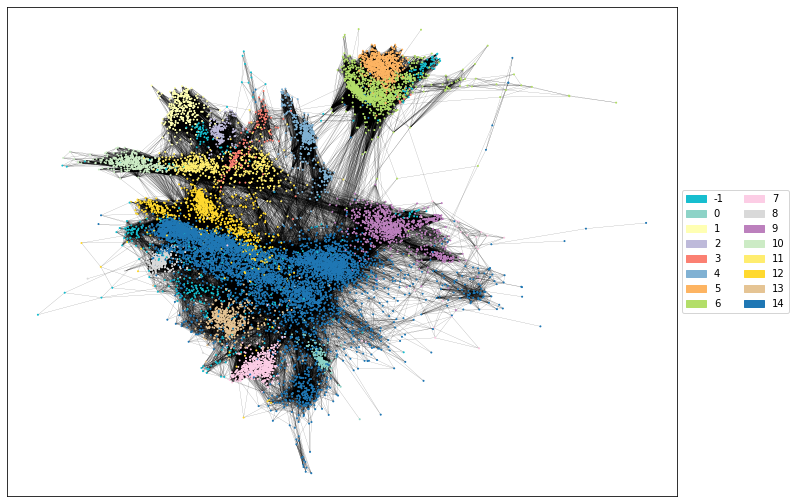

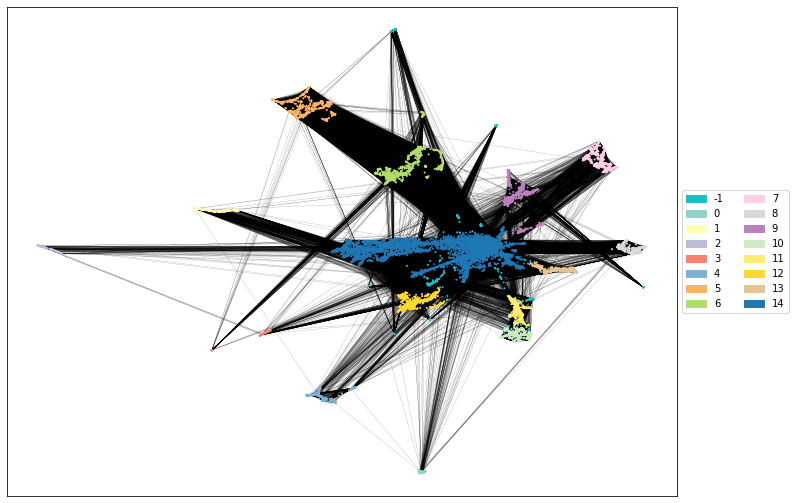

In [11]:
np.random.seed(seed)

def draw_network(G, pos, patch_list, node_colors, pdf_name, node_size=1, edge_width=.1, font_size=1):
    plt.figure(figsize=(12, 9))
    nx.draw_networkx_nodes(G, pos=pos, node_size=node_size, node_color=node_colors)
    nx.draw_networkx_edges(G, pos=pos, width=edge_width)
    # nx.draw_networkx_labels(G, pos=pos, font_size=font_size)
    plt.legend(handles=patch_list, loc="center left", bbox_to_anchor=(1, 0.5), ncol=2, fancybox=True)
    plt.savefig(f"results/{pdf_name + pdf_postfix}.pdf", bbox_inches="tight")
    plt.show()

palette = plt.cm.Set3.colors \
          + plt.cm.Set2.colors[5:7] \
          + plt.cm.tab10.colors[:-1] \
          + tuple(plt.cm.tab20c.colors[i] for i in [4]) \
          + tuple(plt.cm.tab20b.colors[i] for i in [0, 4, 8, 12, 16]) \
          + plt.cm.tab10.colors[-1:]

if np.amax(clusters) + 1 < 30:
    node_colors = [palette[cluster] for cluster in clusters]
    patch_list = [Patch(color=palette[i], label=i) for i in range(-1, np.amax(clusters) + 1)]
else:
    print("ERROR: cannot visualize more than 29 clusters...")
    node_colors = [palette[-1] for cluster in clusters]
    patch_list = [Patch(color=palette[-1], label=-1)]

pos_sp = nx.spring_layout(G, seed=seed)
pos_su = {node_list[i]: embedding[i] for i in range(len(node_list))}

draw_network(G, pos=pos_sp, patch_list=patch_list, node_colors=node_colors, pdf_name="graph_sp")
draw_network(G, pos=pos_su, patch_list=patch_list, node_colors=node_colors, pdf_name="graph_su")

Visualizing actors' birth years using custom layout:

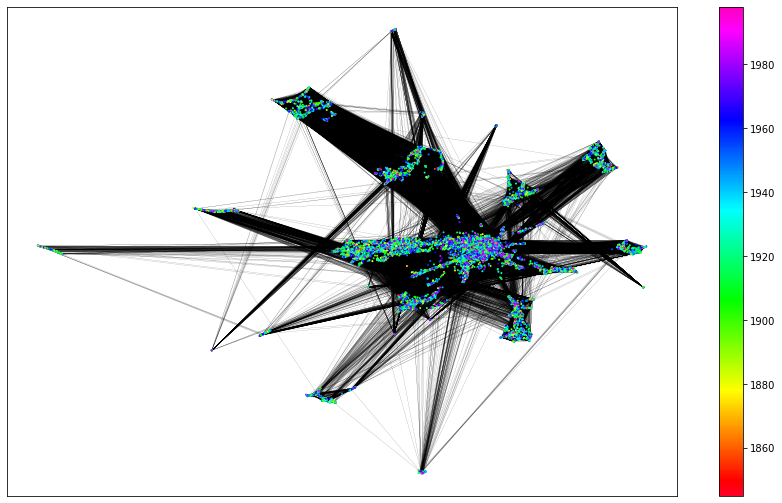

In [12]:
np.random.seed(seed)

birth_years = df_actor_info.sort_values(by="nconst", ascending=True)["birth_year"].values
birth_years[birth_years == "\\N"] = np.nan
birth_years = birth_years.astype(float)

plt.figure(figsize=(15, 9))
g = nx.draw_networkx_nodes(
    G, pos=pos_su, node_size=1, node_color=birth_years, cmap=plt.cm.gist_rainbow, vmin=np.nanmin(birth_years),
    vmax=np.nanmax(birth_years)
)
nx.draw_networkx_edges(G, pos=pos_su, width=.1)
plt.colorbar(g)
plt.savefig(f"results/birth_years_su{pdf_postfix}.pdf", bbox_inches="tight")
plt.show()